# imports

In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from data_viz_functions import *

random_seed = 42

# reading data

In [2]:
DATA_DIR = 'kaggle/input'

df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# preprocessing

In [3]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [4]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [5]:
# Заподнение пропускоы в ['education'] наиболее частым значением 'SCH'
data["education"].fillna(data.education.mode(), inplace=True)

In [6]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [7]:
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [8]:
data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)

In [9]:
# Нормализация численных данных
for column in num_cols:
    data[column] = StandardScaler().fit_transform(np.array(data[column].values).reshape(-1, 1))

In [10]:
data.sample(5, random_state=random_seed).T

,74834,17526,75682,26882,28861
sex,0.000000,1.000000,0.000000,0.000000,1.000000
age,-1.130811,-0.773745,1.362924,-0.347997,-1.007707
car,0.000000,1.000000,0.000000,1.000000,0.000000
car_type,0.000000,1.000000,0.000000,0.000000,0.000000
decline_app_cnt,-0.418815,-0.418815,-0.418815,-0.418815,-0.418815
good_work,0.000000,0.000000,0.000000,0.000000,0.000000
score_bki,0.368124,-0.250086,-1.383239,0.317360,-0.992421
bki_request_cnt,1.109345,-1.334144,-1.334144,-0.281790,-0.281790
region_rating,6.000000,4.000000,3.000000,3.000000,3.000000
home_address,1.000000,1.000000,0.000000,0.000000,1.000000


# undersampling

In [11]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [12]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [13]:
# undersampling

rus = RandomUnderSampler(random_state=random_seed)
X_us, y_us = rus.fit_resample(X, y)


X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(
    X_us, y_us, test_size=0.10, shuffle=True, random_state=random_seed
)

# simple model

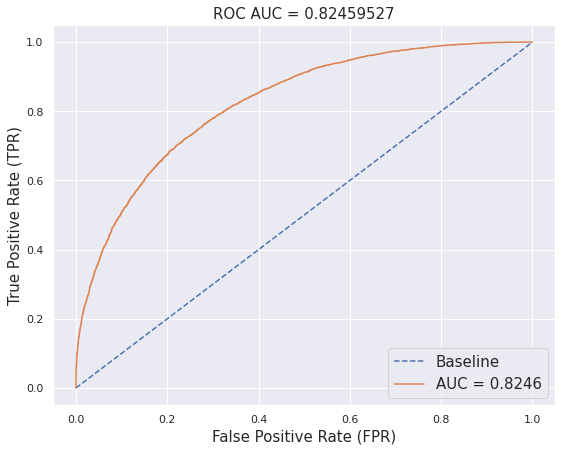

In [14]:
plot_roc_auc(
    y_train_us,
    CatBoostClassifier(silent=True)
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

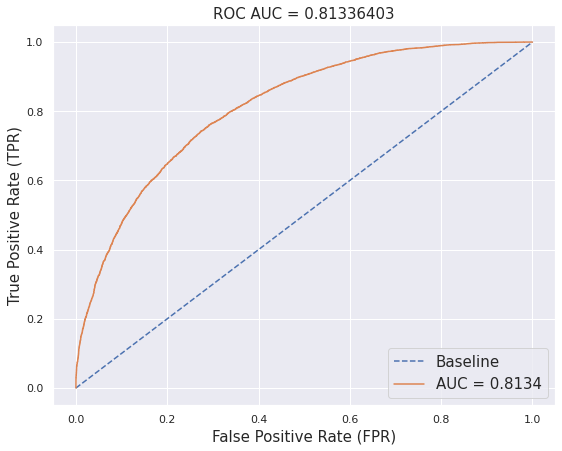

In [15]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

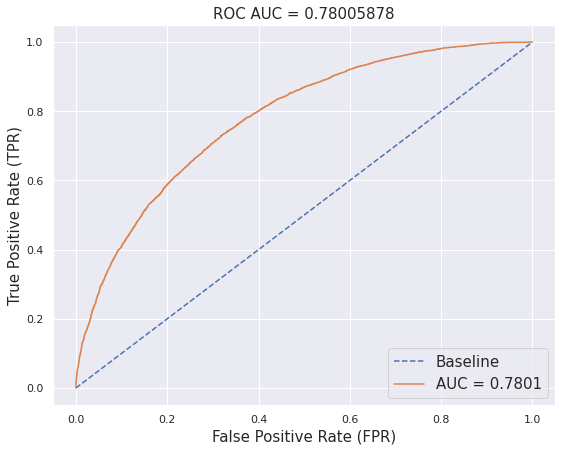

In [16]:
plot_roc_auc(
    y_train_us,
    HistGradientBoostingClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

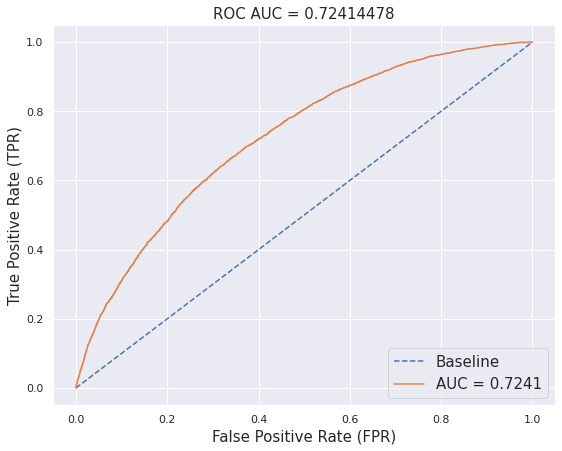

In [17]:
plot_roc_auc(
    y_train_us,
    LogisticRegression(solver="saga", max_iter=1000, random_state=random_seed) # уже хорошо отгридсёрченная в бейзлайне
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)


# parameter tuning

In [21]:
import optuna


def objective(trial):

    import lightgbm as lgb
    from sklearn.model_selection import cross_val_score
    # from sklearn.metrics import roc_auc_score

    # train_x, test_x, train_y, test_y = train_test_split(
    #     X_us, y_us, test_size=0.25, random_state=random_seed
    # )
    # dtrain = lgb.Dataset(train_x, label=train_y)
    # dtrain = lgb.Dataset(X_us, label=y_us)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # gbm = lgb.train(param, dtrain)
    gbm = LGBMClassifier(**param)
    cv_roc_auc = cross_val_score(gbm, X_us, y_us, cv=8, scoring="roc_auc", n_jobs=-1)

    # preds = gbm.predict(test_x)
    # pred_labels = np.rint(preds)

    # score = roc_auc_score(test_y, pred_labels)
    score = np.median(cv_roc_auc)
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=600, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2021-12-19 09:46:42,650] A new study created in memory with name: no-name-6a38680c-c55f-434b-b378-dc6cacde68b6


[LightGBM] [Warning] bagging_fraction is set=0.7932982549289107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7932982549289107
[LightGBM] [Warning] lambda_l1 is set=2.4307311629465444e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4307311629465444e-05
[LightGBM] [Warning] feature_fraction is set=0.731555469698062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.731555469698062
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2413345669984075e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2413345669984075e-07
[LightGBM] [Warning] bagging_fraction is set=0.7932982549289107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7932982549289107
[LightGBM] [Warning] lambda_l1 is set=2.4307311629465444e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4307311629465444e-05
[LightGBM] [Warning] f

[I 2021-12-19 09:46:48,172] Trial 0 finished with value: 0.7187673963795128 and parameters: {'lambda_l1': 2.4307311629465444e-05, 'lambda_l2': 1.2413345669984075e-07, 'num_leaves': 46, 'feature_fraction': 0.731555469698062, 'bagging_fraction': 0.7932982549289107, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.9284486946670677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284486946670677
[LightGBM] [Warning] lambda_l1 is set=0.04536089107157454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04536089107157454
[LightGBM] [Warning] feature_fraction is set=0.9163821362719615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9163821362719615
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0001462671279172315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001462671279172315
[LightGBM] [Warning] bagging_fraction is set=0.9284486946670677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9284486946670677
[LightGBM] [Warning] lambda_l1 is set=0.04536089107157454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04536089107157454
[LightGBM] [Warning] feature_fract

[I 2021-12-19 09:46:53,547] Trial 1 finished with value: 0.7005767947234504 and parameters: {'lambda_l1': 0.04536089107157454, 'lambda_l2': 0.0001462671279172315, 'num_leaves': 168, 'feature_fraction': 0.9163821362719615, 'bagging_fraction': 0.9284486946670677, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.6708709626909981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708709626909981
[LightGBM] [Warning] lambda_l1 is set=1.4186067726100974e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4186067726100974e-05
[LightGBM] [Warning] feature_fraction is set=0.9394695916004825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9394695916004825
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.670892071796471e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.670892071796471e-07
[LightGBM] [Warning] bagging_fraction is set=0.6708709626909981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6708709626909981
[LightGBM] [Warning] lambda_l1 is set=1.4186067726100974e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4186067726100974e-05
[LightGBM] [Warning] f

[I 2021-12-19 09:46:56,371] Trial 2 finished with value: 0.7047195011410569 and parameters: {'lambda_l1': 1.4186067726100974e-05, 'lambda_l2': 3.670892071796471e-07, 'num_leaves': 90, 'feature_fraction': 0.9394695916004825, 'bagging_fraction': 0.6708709626909981, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.9252209531069999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9252209531069999
[LightGBM] [Warning] lambda_l1 is set=4.30298884035161e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.30298884035161e-07
[LightGBM] [Warning] feature_fraction is set=0.44689989750882025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44689989750882025
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.005978869087768468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005978869087768468
[LightGBM] [Warning] bagging_fraction is set=0.9252209531069999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9252209531069999
[LightGBM] [Warning] lambda_l1 is set=4.30298884035161e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.30298884035161e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 09:47:00,879] Trial 3 finished with value: 0.7142556316907751 and parameters: {'lambda_l1': 4.30298884035161e-07, 'lambda_l2': 0.005978869087768468, 'num_leaves': 208, 'feature_fraction': 0.44689989750882025, 'bagging_fraction': 0.9252209531069999, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.9891491169987039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891491169987039
[LightGBM] [Warning] lambda_l1 is set=0.02179693700671588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02179693700671588
[LightGBM] [Warning] feature_fraction is set=0.7705612175527405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7705612175527405
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.74984611074279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.74984611074279e-05
[LightGBM] [Warning] bagging_fraction is set=0.9891491169987039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891491169987039
[LightGBM] [Warning] lambda_l1 is set=0.02179693700671588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02179693700671588
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 09:47:05,583] Trial 4 finished with value: 0.7065072296074357 and parameters: {'lambda_l1': 0.02179693700671588, 'lambda_l2': 6.74984611074279e-05, 'num_leaves': 173, 'feature_fraction': 0.7705612175527405, 'bagging_fraction': 0.9891491169987039, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.6647058329855275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6647058329855275
[LightGBM] [Warning] lambda_l1 is set=4.024259810689697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.024259810689697
[LightGBM] [Warning] feature_fraction is set=0.42790475018916657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42790475018916657
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007841367991150894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007841367991150894
[LightGBM] [Warning] bagging_fraction is set=0.6647058329855275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6647058329855275
[LightGBM] [Warning] lambda_l1 is set=4.024259810689697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.024259810689697
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 09:47:09,229] Trial 5 finished with value: 0.716614617184927 and parameters: {'lambda_l1': 4.024259810689697, 'lambda_l2': 0.0007841367991150894, 'num_leaves': 138, 'feature_fraction': 0.42790475018916657, 'bagging_fraction': 0.6647058329855275, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.8454686254501719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8454686254501719
[LightGBM] [Warning] lambda_l1 is set=1.64217300728605e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.64217300728605e-06
[LightGBM] [Warning] feature_fraction is set=0.6795954033722136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6795954033722136
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0383256519018599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0383256519018599
[LightGBM] [Warning] bagging_fraction is set=0.8454686254501719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8454686254501719
[LightGBM] [Warning] lambda_l1 is set=1.64217300728605e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.64217300728605e-06
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 09:47:15,216] Trial 6 finished with value: 0.7040735580860559 and parameters: {'lambda_l1': 1.64217300728605e-06, 'lambda_l2': 0.0383256519018599, 'num_leaves': 213, 'feature_fraction': 0.6795954033722136, 'bagging_fraction': 0.8454686254501719, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.7709108733624561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7709108733624561
[LightGBM] [Warning] lambda_l1 is set=5.709944420023281e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.709944420023281e-08
[LightGBM] [Warning] feature_fraction is set=0.4143713035461971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4143713035461971
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.61919958155014e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.61919958155014e-08
[LightGBM] [Warning] bagging_fraction is set=0.7709108733624561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7709108733624561
[LightGBM] [Warning] lambda_l1 is set=5.709944420023281e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.709944420023281e-08
[LightGBM] [Warning] feature

[I 2021-12-19 09:47:19,702] Trial 7 finished with value: 0.7054812986187822 and parameters: {'lambda_l1': 5.709944420023281e-08, 'lambda_l2': 3.61919958155014e-08, 'num_leaves': 128, 'feature_fraction': 0.4143713035461971, 'bagging_fraction': 0.7709108733624561, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.7241455145085631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7241455145085631
[LightGBM] [Warning] lambda_l1 is set=8.982626546017793e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.982626546017793e-07
[LightGBM] [Warning] feature_fraction is set=0.6841231517708568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6841231517708568
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0002011917528349685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002011917528349685
[LightGBM] [Warning] bagging_fraction is set=0.7241455145085631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7241455145085631
[LightGBM] [Warning] lambda_l1 is set=8.982626546017793e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.982626546017793e-07
[LightGBM] [Warning] featu

[I 2021-12-19 09:47:24,466] Trial 8 finished with value: 0.7089820695243119 and parameters: {'lambda_l1': 8.982626546017793e-07, 'lambda_l2': 0.0002011917528349685, 'num_leaves': 119, 'feature_fraction': 0.6841231517708568, 'bagging_fraction': 0.7241455145085631, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.4884549808511635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4884549808511635
[LightGBM] [Warning] lambda_l1 is set=0.0013320098749625721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013320098749625721
[LightGBM] [Warning] feature_fraction is set=0.7800966449519917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7800966449519917
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.485385428058177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.485385428058177
[LightGBM] [Warning] bagging_fraction is set=0.4884549808511635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4884549808511635
[LightGBM] [Warning] lambda_l1 is set=0.0013320098749625721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013320098749625721
[LightGBM] [Warning] feature_fract

[I 2021-12-19 09:47:29,451] Trial 9 finished with value: 0.697876803758638 and parameters: {'lambda_l1': 0.0013320098749625721, 'lambda_l2': 0.485385428058177, 'num_leaves': 253, 'feature_fraction': 0.7800966449519917, 'bagging_fraction': 0.4884549808511635, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.501254480743364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.501254480743364
[LightGBM] [Warning] lambda_l1 is set=9.682765707894704e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.682765707894704e-05
[LightGBM] [Warning] feature_fraction is set=0.5724812478877879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5724812478877879
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.971627141349434e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.971627141349434e-06
[LightGBM] [Warning] bagging_fraction is set=0.501254480743364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.501254480743364
[LightGBM] [Warning] lambda_l1 is set=9.682765707894704e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.682765707894704e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 09:47:32,257] Trial 10 finished with value: 0.7173399824542483 and parameters: {'lambda_l1': 9.682765707894704e-05, 'lambda_l2': 1.971627141349434e-06, 'num_leaves': 19, 'feature_fraction': 0.5724812478877879, 'bagging_fraction': 0.501254480743364, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.44105036414723825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44105036414723825
[LightGBM] [Warning] lambda_l1 is set=7.211623005902062e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.211623005902062e-05
[LightGBM] [Warning] feature_fraction is set=0.573946097272701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.573946097272701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.44105036414723825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44105036414723825
[LightGBM] [Warning] lambda_l1 is set=7.211623005902062e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.211623005902062e-05
[LightGBM] [Warning] feature_fraction is set=0.573946097272701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.573946097272701
[LightGBM] [

[I 2021-12-19 09:47:33,950] Trial 11 finished with value: 0.7172131983690029 and parameters: {'lambda_l1': 7.211623005902062e-05, 'lambda_l2': 8.057097598126078e-07, 'num_leaves': 2, 'feature_fraction': 0.573946097272701, 'bagging_fraction': 0.44105036414723825, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 0 with value: 0.7187673963795128.


[LightGBM] [Warning] bagging_fraction is set=0.5395341861730725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5395341861730725
[LightGBM] [Warning] lambda_l1 is set=0.0010548885497315428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010548885497315428
[LightGBM] [Warning] feature_fraction is set=0.5803171994927172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5803171994927172
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.6934569749557116e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6934569749557116e-06
[LightGBM] [Warning] bagging_fraction is set=0.5395341861730725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5395341861730725
[LightGBM] [Warning] lambda_l1 is set=0.0010548885497315428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010548885497315428
[LightGBM] [Warning] fea

[I 2021-12-19 09:47:36,393] Trial 12 finished with value: 0.7208199870009879 and parameters: {'lambda_l1': 0.0010548885497315428, 'lambda_l2': 2.6934569749557116e-06, 'num_leaves': 19, 'feature_fraction': 0.5803171994927172, 'bagging_fraction': 0.5395341861730725, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.5872675468733402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5872675468733402
[LightGBM] [Warning] lambda_l1 is set=0.02333689230996966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02333689230996966
[LightGBM] [Warning] feature_fraction is set=0.5812903610883543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5812903610883543
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.6905089697986413e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6905089697986413e-08
[LightGBM] [Warning] bagging_fraction is set=0.5872675468733402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5872675468733402[LightGBM] [Warning] bagging_fraction is set=0.5872675468733402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5872675468733402
[LightGBM] [Warning] 

[I 2021-12-19 09:47:39,518] Trial 13 finished with value: 0.7114751255453902 and parameters: {'lambda_l1': 0.02333689230996966, 'lambda_l2': 1.6905089697986413e-08, 'num_leaves': 52, 'feature_fraction': 0.5812903610883543, 'bagging_fraction': 0.5872675468733402, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.5834500970920555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5834500970920555
[LightGBM] [Warning] lambda_l1 is set=0.0012247498084349967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012247498084349967
[LightGBM] [Warning] feature_fraction is set=0.8160838240366259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8160838240366259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.251389778409154e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.251389778409154e-06
[LightGBM] [Warning] bagging_fraction is set=0.5834500970920555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5834500970920555
[LightGBM] [Warning] lambda_l1 is set=0.0012247498084349967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012247498084349967[LightGBM] [Warning] baggin

[I 2021-12-19 09:47:41,936] Trial 14 finished with value: 0.7115141080083823 and parameters: {'lambda_l1': 0.0012247498084349967, 'lambda_l2': 7.251389778409154e-06, 'num_leaves': 54, 'feature_fraction': 0.8160838240366259, 'bagging_fraction': 0.5834500970920555, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.8181165146258949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8181165146258949
[LightGBM] [Warning] lambda_l1 is set=0.5755864867651289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5755864867651289
[LightGBM] [Warning] feature_fraction is set=0.6273057160635631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273057160635631
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.461662130217423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.461662130217423
[LightGBM] [Warning] bagging_fraction is set=0.8181165146258949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8181165146258949
[LightGBM] [Warning] lambda_l1 is set=0.5755864867651289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5755864867651289
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 09:47:44,892] Trial 15 finished with value: 0.7205234288245804 and parameters: {'lambda_l1': 0.5755864867651289, 'lambda_l2': 9.461662130217423, 'num_leaves': 46, 'feature_fraction': 0.6273057160635631, 'bagging_fraction': 0.8181165146258949, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.5917767286240859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5917767286240859
[LightGBM] [Warning] lambda_l1 is set=3.3095983556939026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3095983556939026
[LightGBM] [Warning] feature_fraction is set=0.5245320860504817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5245320860504817
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.748881131509988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.748881131509988
[LightGBM] [Warning] bagging_fraction is set=0.5917767286240859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5917767286240859
[LightGBM] [Warning] lambda_l1 is set=3.3095983556939026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3095983556939026
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 09:47:47,710] Trial 16 finished with value: 0.7199980763793963 and parameters: {'lambda_l1': 3.3095983556939026, 'lambda_l2': 9.748881131509988, 'num_leaves': 88, 'feature_fraction': 0.5245320860504817, 'bagging_fraction': 0.5917767286240859, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.8412264436084582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412264436084582
[LightGBM] [Warning] lambda_l1 is set=0.25043661613816637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25043661613816637
[LightGBM] [Warning] feature_fraction is set=0.6408471062474446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408471062474446
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.6068189371665257e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6068189371665257e-05
[LightGBM] [Warning] bagging_fraction is set=0.8412264436084582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412264436084582
[LightGBM] [Warning] lambda_l1 is set=0.25043661613816637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25043661613816637
[LightGBM] [Warning] feature_fra

[I 2021-12-19 09:47:50,242] Trial 17 finished with value: 0.7169647307076884 and parameters: {'lambda_l1': 0.25043661613816637, 'lambda_l2': 1.6068189371665257e-05, 'num_leaves': 27, 'feature_fraction': 0.6408471062474446, 'bagging_fraction': 0.8412264436084582, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.5183043794113825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5183043794113825
[LightGBM] [Warning] lambda_l1 is set=0.6710839603485321, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6710839603485321
[LightGBM] [Warning] feature_fraction is set=0.5025263602382752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5025263602382752
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.561600198424238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.561600198424238
[LightGBM] [Warning] bagging_fraction is set=0.5183043794113825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5183043794113825
[LightGBM] [Warning] lambda_l1 is set=0.6710839603485321, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6710839603485321
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 09:47:53,142] Trial 18 finished with value: 0.7189419066577675 and parameters: {'lambda_l1': 0.6710839603485321, 'lambda_l2': 4.561600198424238, 'num_leaves': 82, 'feature_fraction': 0.5025263602382752, 'bagging_fraction': 0.5183043794113825, 'bagging_freq': 3, 'min_child_samples': 72}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.4028640757299805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4028640757299805
[LightGBM] [Warning] lambda_l1 is set=0.0030468450021833163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030468450021833163
[LightGBM] [Warning] feature_fraction is set=0.8603076066545917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603076066545917
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.08694567532845232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08694567532845232
[LightGBM] [Warning] bagging_fraction is set=0.4028640757299805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4028640757299805
[LightGBM] [Warning] lambda_l1 is set=0.0030468450021833163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030468450021833163
[LightGBM] [Warning] feature_f

[I 2021-12-19 09:47:54,297] Trial 19 finished with value: 0.7172618353672222 and parameters: {'lambda_l1': 0.0030468450021833163, 'lambda_l2': 0.08694567532845232, 'num_leaves': 2, 'feature_fraction': 0.8603076066545917, 'bagging_fraction': 0.4028640757299805, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.6271013120849912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6271013120849912
[LightGBM] [Warning] lambda_l1 is set=0.21328114409126983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21328114409126983
[LightGBM] [Warning] feature_fraction is set=0.6268826244498118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6268826244498118
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0015609978399822992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015609978399822992
[LightGBM] [Warning] bagging_fraction is set=0.6271013120849912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6271013120849912
[LightGBM] [Warning] lambda_l1 is set=0.21328114409126983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21328114409126983
[LightGBM] [Warning] feature_fract

[I 2021-12-19 09:47:57,475] Trial 20 finished with value: 0.706519980880377 and parameters: {'lambda_l1': 0.21328114409126983, 'lambda_l2': 0.0015609978399822992, 'num_leaves': 70, 'feature_fraction': 0.6268826244498118, 'bagging_fraction': 0.6271013120849912, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.5609919877709508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5609919877709508
[LightGBM] [Warning] lambda_l1 is set=3.1285011058655567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1285011058655567
[LightGBM] [Warning] feature_fraction is set=0.5228220022634924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5228220022634924
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.942574225558843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.942574225558843
[LightGBM] [Warning] bagging_fraction is set=0.5609919877709508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5609919877709508
[LightGBM] [Warning] lambda_l1 is set=3.1285011058655567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1285011058655567
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 09:48:00,514] Trial 21 finished with value: 0.7192938417909491 and parameters: {'lambda_l1': 3.1285011058655567, 'lambda_l2': 9.942574225558843, 'num_leaves': 92, 'feature_fraction': 0.5228220022634924, 'bagging_fraction': 0.5609919877709508, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 12 with value: 0.7208199870009879.


[LightGBM] [Warning] bagging_fraction is set=0.7214085367378689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7214085367378689
[LightGBM] [Warning] lambda_l1 is set=7.254547955326378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.254547955326378
[LightGBM] [Warning] feature_fraction is set=0.5072959811130213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072959811130213
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0139301196734463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0139301196734463
[LightGBM] [Warning] bagging_fraction is set=0.7214085367378689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7214085367378689
[LightGBM] [Warning] lambda_l1 is set=7.254547955326378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.254547955326378
[LightGBM] [Warning] feature_fraction is set=0.5

[I 2021-12-19 09:48:02,997] Trial 22 finished with value: 0.7211373115361859 and parameters: {'lambda_l1': 7.254547955326378, 'lambda_l2': 1.0139301196734463, 'num_leaves': 35, 'feature_fraction': 0.5072959811130213, 'bagging_fraction': 0.7214085367378689, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 22 with value: 0.7211373115361859.


[LightGBM] [Warning] bagging_fraction is set=0.7341080570445765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7341080570445765
[LightGBM] [Warning] bagging_fraction is set=0.7341080570445765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7341080570445765
[LightGBM] [Warning] lambda_l1 is set=0.2793638529099863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2793638529099863
[LightGBM] [Warning] feature_fraction is set=0.4721099961984104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4721099961984104
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.4573658588818966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4573658588818966
[LightGBM] [Warning] lambda_l1 is set=0.2793638529099863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2793638529099863
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:48:05,696] Trial 23 finished with value: 0.7192446583096038 and parameters: {'lambda_l1': 0.2793638529099863, 'lambda_l2': 0.4573658588818966, 'num_leaves': 35, 'feature_fraction': 0.4721099961984104, 'bagging_fraction': 0.7341080570445765, 'bagging_freq': 2, 'min_child_samples': 98}. Best is trial 22 with value: 0.7211373115361859.


[LightGBM] [Warning] bagging_fraction is set=0.8260267026316269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8260267026316269
[LightGBM] [Warning] lambda_l1 is set=6.716025971510605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.716025971510605
[LightGBM] [Warning] feature_fraction is set=0.6102414443739893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6102414443739893
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.4738833801133338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4738833801133338
[LightGBM] [Warning] bagging_fraction is set=0.8260267026316269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8260267026316269
[LightGBM] [Warning] lambda_l1 is set=6.716025971510605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.716025971510605
[LightGBM] [Warning] feature_fraction is set=0.6

[I 2021-12-19 09:48:07,841] Trial 24 finished with value: 0.7220586820867203 and parameters: {'lambda_l1': 6.716025971510605, 'lambda_l2': 0.4738833801133338, 'num_leaves': 17, 'feature_fraction': 0.6102414443739893, 'bagging_fraction': 0.8260267026316269, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 24 with value: 0.7220586820867203.


[LightGBM] [Warning] bagging_fraction is set=0.8830341576221782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8830341576221782
[LightGBM] [Warning] lambda_l1 is set=1.1147353162113875e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1147353162113875e-08
[LightGBM] [Warning] feature_fraction is set=0.9987553366035409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9987553366035409
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.011005908903938183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011005908903938183
[LightGBM] [Warning] bagging_fraction is set=0.8830341576221782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8830341576221782
[LightGBM] [Warning] lambda_l1 is set=1.1147353162113875e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1147353162113875e-08
[LightGBM] [Warning] fea

[I 2021-12-19 09:48:10,024] Trial 25 finished with value: 0.7207842834367524 and parameters: {'lambda_l1': 1.1147353162113875e-08, 'lambda_l2': 0.011005908903938183, 'num_leaves': 19, 'feature_fraction': 0.9987553366035409, 'bagging_fraction': 0.8830341576221782, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 24 with value: 0.7220586820867203.


[LightGBM] [Warning] bagging_fraction is set=0.7599509217999317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7599509217999317
[LightGBM] [Warning] lambda_l1 is set=9.956590732306218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.956590732306218
[LightGBM] [Warning] feature_fraction is set=0.5539447292860137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5539447292860137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.6539446543473587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6539446543473587
[LightGBM] [Warning] bagging_fraction is set=0.7599509217999317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7599509217999317
[LightGBM] [Warning] lambda_l1 is set=9.956590732306218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.956590732306218
[LightGBM] [Warning] feature_fraction is set=0.5

[I 2021-12-19 09:48:12,684] Trial 26 finished with value: 0.7223457678889429 and parameters: {'lambda_l1': 9.956590732306218, 'lambda_l2': 0.6539446543473587, 'num_leaves': 70, 'feature_fraction': 0.5539447292860137, 'bagging_fraction': 0.7599509217999317, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 26 with value: 0.7223457678889429.


[LightGBM] [Warning] bagging_fraction is set=0.7649135234995347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7649135234995347
[LightGBM] [Warning] lambda_l1 is set=9.673962763656592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.673962763656592
[LightGBM] [Warning] feature_fraction is set=0.5304142775947249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5304142775947249
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.8629670109471921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8629670109471921
[LightGBM] [Warning] bagging_fraction is set=0.7649135234995347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7649135234995347[LightGBM] [Warning] bagging_fraction is set=0.7649135234995347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7649135234995347
[LightGBM] [Warning] lambda_l1 is

[I 2021-12-19 09:48:15,492] Trial 27 finished with value: 0.7226310320807454 and parameters: {'lambda_l1': 9.673962763656592, 'lambda_l2': 0.8629670109471921, 'num_leaves': 68, 'feature_fraction': 0.5304142775947249, 'bagging_fraction': 0.7649135234995347, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.7608210429473364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7608210429473364
[LightGBM] [Warning] lambda_l1 is set=0.06679504303263299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06679504303263299
[LightGBM] [Warning] feature_fraction is set=0.5439878902849096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5439878902849096
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0963610375785421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0963610375785421
[LightGBM] [Warning] bagging_fraction is set=0.7608210429473364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7608210429473364
[LightGBM] [Warning] lambda_l1 is set=0.06679504303263299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06679504303263299
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 09:48:18,907] Trial 28 finished with value: 0.7101369705307153 and parameters: {'lambda_l1': 0.06679504303263299, 'lambda_l2': 0.0963610375785421, 'num_leaves': 67, 'feature_fraction': 0.5439878902849096, 'bagging_fraction': 0.7608210429473364, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.7869070261339136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7869070261339136
[LightGBM] [Warning] lambda_l1 is set=1.9132485793553433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9132485793553433
[LightGBM] [Warning] feature_fraction is set=0.7097906884113635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7097906884113635
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.2340916223281877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2340916223281877
[LightGBM] [Warning] bagging_fraction is set=0.7869070261339136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7869070261339136
[LightGBM] [Warning] lambda_l1 is set=1.9132485793553433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9132485793553433
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:48:22,515] Trial 29 finished with value: 0.7120037568893306 and parameters: {'lambda_l1': 1.9132485793553433, 'lambda_l2': 1.2340916223281877, 'num_leaves': 109, 'feature_fraction': 0.7097906884113635, 'bagging_fraction': 0.7869070261339136, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.884430265878479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884430265878479
[LightGBM] [Warning] lambda_l1 is set=0.008135589569400728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008135589569400728
[LightGBM] [Warning] feature_fraction is set=0.6481345166482777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6481345166482777
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.2130583928407747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2130583928407747
[LightGBM] [Warning] bagging_fraction is set=0.884430265878479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884430265878479
[LightGBM] [Warning] lambda_l1 is set=0.008135589569400728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008135589569400728
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 09:48:26,163] Trial 30 finished with value: 0.7126471496897433 and parameters: {'lambda_l1': 0.008135589569400728, 'lambda_l2': 0.2130583928407747, 'num_leaves': 63, 'feature_fraction': 0.6481345166482777, 'bagging_fraction': 0.884430265878479, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.6876855009729563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6876855009729563
[LightGBM] [Warning] lambda_l1 is set=8.241493655507059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.241493655507059
[LightGBM] [Warning] feature_fraction is set=0.4824962989266746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4824962989266746
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.3779043104045956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3779043104045956
[LightGBM] [Warning] bagging_fraction is set=0.6876855009729563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6876855009729563[LightGBM] [Warning] bagging_fraction is set=0.6876855009729563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6876855009729563
[LightGBM] [Warning] lambda_l1 is

[I 2021-12-19 09:48:28,489] Trial 31 finished with value: 0.7215096487060737 and parameters: {'lambda_l1': 8.241493655507059, 'lambda_l2': 1.3779043104045956, 'num_leaves': 38, 'feature_fraction': 0.4824962989266746, 'bagging_fraction': 0.6876855009729563, 'bagging_freq': 4, 'min_child_samples': 96}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.6834609904150915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6834609904150915
[LightGBM] [Warning] lambda_l1 is set=9.82799395528109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.82799395528109
[LightGBM] [Warning] feature_fraction is set=0.4639253449608302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639253449608302
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6834609904150915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6834609904150915
[LightGBM] [Warning] lambda_l1 is set=9.82799395528109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.82799395528109
[LightGBM] [Warning] feature_fraction is set=0.4639253449608302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639253449608302
[LightGBM] [Warning] bagging_fre

[I 2021-12-19 09:48:30,728] Trial 32 finished with value: 0.722372727723162 and parameters: {'lambda_l1': 9.82799395528109, 'lambda_l2': 2.2652520834968075, 'num_leaves': 108, 'feature_fraction': 0.4639253449608302, 'bagging_fraction': 0.6834609904150915, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.6515345887197942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6515345887197942
[LightGBM] [Warning] lambda_l1 is set=1.0761461083751636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0761461083751636
[LightGBM] [Warning] feature_fraction is set=0.45688063290652314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45688063290652314
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.009518047613530294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009518047613530294
[LightGBM] [Warning] bagging_fraction is set=0.6515345887197942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6515345887197942
[LightGBM] [Warning] lambda_l1 is set=1.0761461083751636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0761461083751636
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 09:48:33,770] Trial 33 finished with value: 0.7171403339521951 and parameters: {'lambda_l1': 1.0761461083751636, 'lambda_l2': 0.009518047613530294, 'num_leaves': 106, 'feature_fraction': 0.45688063290652314, 'bagging_fraction': 0.6515345887197942, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.807253666178079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.807253666178079
[LightGBM] [Warning] lambda_l1 is set=9.987508533484847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.987508533484847
[LightGBM] [Warning] feature_fraction is set=0.5484140703444014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484140703444014
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.04140475476888565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04140475476888565
[LightGBM] [Warning] bagging_fraction is set=0.807253666178079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.807253666178079
[LightGBM] [Warning] lambda_l1 is set=9.987508533484847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.987508533484847
[LightGBM] [Warning] feature_fraction is set=0.548

[I 2021-12-19 09:48:36,469] Trial 34 finished with value: 0.7218153149345823 and parameters: {'lambda_l1': 9.987508533484847, 'lambda_l2': 0.04140475476888565, 'num_leaves': 154, 'feature_fraction': 0.5484140703444014, 'bagging_fraction': 0.807253666178079, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.7480065828015173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7480065828015173
[LightGBM] [Warning] lambda_l1 is set=0.08501872380670875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08501872380670875
[LightGBM] [Warning] feature_fraction is set=0.4053368688705671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4053368688705671
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.605951381244664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.605951381244664
[LightGBM] [Warning] bagging_fraction is set=0.7480065828015173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7480065828015173
[LightGBM] [Warning] lambda_l1 is set=0.08501872380670875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08501872380670875
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 09:48:39,784] Trial 35 finished with value: 0.7145864361430825 and parameters: {'lambda_l1': 0.08501872380670875, 'lambda_l2': 2.605951381244664, 'num_leaves': 79, 'feature_fraction': 0.4053368688705671, 'bagging_fraction': 0.7480065828015173, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.9294268211500611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9294268211500611
[LightGBM] [Warning] lambda_l1 is set=1.2262229202835857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2262229202835857
[LightGBM] [Warning] feature_fraction is set=0.4840320253132425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4840320253132425
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.2577528839499329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2577528839499329
[LightGBM] [Warning] bagging_fraction is set=0.9294268211500611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9294268211500611
[LightGBM] [Warning] lambda_l1 is set=1.2262229202835857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2262229202835857
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:48:43,306] Trial 36 finished with value: 0.7127502528395262 and parameters: {'lambda_l1': 1.2262229202835857, 'lambda_l2': 0.2577528839499329, 'num_leaves': 100, 'feature_fraction': 0.4840320253132425, 'bagging_fraction': 0.9294268211500611, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.7013146242714912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7013146242714912
[LightGBM] [Warning] lambda_l1 is set=1.5655912611819116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5655912611819116
[LightGBM] [Warning] feature_fraction is set=0.44063427681230327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44063427681230327
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00222834005315336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00222834005315336
[LightGBM] [Warning] bagging_fraction is set=0.7013146242714912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7013146242714912
[LightGBM] [Warning] lambda_l1 is set=1.5655912611819116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5655912611819116
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 09:48:46,506] Trial 37 finished with value: 0.7157125557048467 and parameters: {'lambda_l1': 1.5655912611819116, 'lambda_l2': 0.00222834005315336, 'num_leaves': 137, 'feature_fraction': 0.44063427681230327, 'bagging_fraction': 0.7013146242714912, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.639264209101021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639264209101021
[LightGBM] [Warning] lambda_l1 is set=6.209294626049976e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.209294626049976e-06
[LightGBM] [Warning] feature_fraction is set=0.6053493628336997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6053493628336997
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.037197292079313805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.037197292079313805
[LightGBM] [Warning] bagging_fraction is set=0.639264209101021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639264209101021
[LightGBM] [Warning] lambda_l1 is set=6.209294626049976e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.209294626049976e-06
[LightGBM] [Warning] feature_fra

[I 2021-12-19 09:48:50,320] Trial 38 finished with value: 0.7054765624316897 and parameters: {'lambda_l1': 6.209294626049976e-06, 'lambda_l2': 0.037197292079313805, 'num_leaves': 161, 'feature_fraction': 0.6053493628336997, 'bagging_fraction': 0.639264209101021, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.8517677655997691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8517677655997691
[LightGBM] [Warning] lambda_l1 is set=0.13581628934169443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13581628934169443[LightGBM] [Warning] bagging_fraction is set=0.8517677655997691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8517677655997691
[LightGBM] [Warning] lambda_l1 is set=0.13581628934169443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13581628934169443
[LightGBM] [Warning] feature_fraction is set=0.6643448864613373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643448864613373
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.4510572400289705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4510572400289705

[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 09:48:54,863] Trial 39 finished with value: 0.7088305115373519 and parameters: {'lambda_l1': 0.13581628934169443, 'lambda_l2': 2.4510572400289705, 'num_leaves': 118, 'feature_fraction': 0.6643448864613373, 'bagging_fraction': 0.8517677655997691, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.973966463492755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.973966463492755[LightGBM] [Warning] bagging_fraction is set=0.973966463492755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.973966463492755
[LightGBM] [Warning] lambda_l1 is set=9.795037728061017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.795037728061017
[LightGBM] [Warning] feature_fraction is set=0.7382303379459393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7382303379459393
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.14363183801005255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14363183801005255

[LightGBM] [Warning] lambda_l1 is set=9.795037728061017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.795037728061017
[LightGBM] [Warning] feature_fraction is set=0.738

[I 2021-12-19 09:48:57,922] Trial 40 finished with value: 0.7215063698073174 and parameters: {'lambda_l1': 9.795037728061017, 'lambda_l2': 0.14363183801005255, 'num_leaves': 75, 'feature_fraction': 0.7382303379459393, 'bagging_fraction': 0.973966463492755, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.8096001318653074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8096001318653074
[LightGBM] [Warning] lambda_l1 is set=3.876404783112877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.876404783112877
[LightGBM] [Warning] feature_fraction is set=0.5518907873388701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5518907873388701
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.04194000093890801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04194000093890801
[LightGBM] [Warning] bagging_fraction is set=0.8096001318653074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8096001318653074
[LightGBM] [Warning] lambda_l1 is set=3.876404783112877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.876404783112877
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 09:49:01,197] Trial 41 finished with value: 0.7185240292273749 and parameters: {'lambda_l1': 3.876404783112877, 'lambda_l2': 0.04194000093890801, 'num_leaves': 158, 'feature_fraction': 0.5518907873388701, 'bagging_fraction': 0.8096001318653074, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.780689856062965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780689856062965
[LightGBM] [Warning] bagging_fraction is set=0.780689856062965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780689856062965
[LightGBM] [Warning] lambda_l1 is set=0.5709007360356089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5709007360356089
[LightGBM] [Warning] feature_fraction is set=0.5394444823156547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5394444823156547
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.592125101970987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.592125101970987
[LightGBM] [Warning] lambda_l1 is set=0.5709007360356089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5709007360356089
[LightGBM] [Warning] feature_fraction is set=0.539

[I 2021-12-19 09:49:05,000] Trial 42 finished with value: 0.710199998251254 and parameters: {'lambda_l1': 0.5709007360356089, 'lambda_l2': 0.592125101970987, 'num_leaves': 188, 'feature_fraction': 0.5394444823156547, 'bagging_fraction': 0.780689856062965, 'bagging_freq': 4, 'min_child_samples': 84}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.8152293858933232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8152293858933232
[LightGBM] [Warning] lambda_l1 is set=7.421452824074385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.421452824074385
[LightGBM] [Warning] feature_fraction is set=0.5994751940182101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5994751940182101
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.024050768728610415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024050768728610415
[LightGBM] [Warning] bagging_fraction is set=0.8152293858933232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8152293858933232
[LightGBM] [Warning] lambda_l1 is set=7.421452824074385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.421452824074385
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:49:08,043] Trial 43 finished with value: 0.7215468095586457 and parameters: {'lambda_l1': 7.421452824074385, 'lambda_l2': 0.024050768728610415, 'num_leaves': 138, 'feature_fraction': 0.5994751940182101, 'bagging_fraction': 0.8152293858933232, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.707073371112193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707073371112193
[LightGBM] [Warning] lambda_l1 is set=3.0997518636040673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0997518636040673
[LightGBM] [Warning] feature_fraction is set=0.5574854399892344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5574854399892344
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.4046414768332602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4046414768332602
[LightGBM] [Warning] bagging_fraction is set=0.707073371112193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707073371112193
[LightGBM] [Warning] lambda_l1 is set=3.0997518636040673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0997518636040673
[LightGBM] [Warning] feature_fraction is set=0.5

[I 2021-12-19 09:49:11,475] Trial 44 finished with value: 0.7157311361311327 and parameters: {'lambda_l1': 3.0997518636040673, 'lambda_l2': 0.4046414768332602, 'num_leaves': 174, 'feature_fraction': 0.5574854399892344, 'bagging_fraction': 0.707073371112193, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.8656069929872864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8656069929872864
[LightGBM] [Warning] lambda_l1 is set=0.5097825052022863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5097825052022863
[LightGBM] [Warning] feature_fraction is set=0.5058250605018793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5058250605018793
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.4811446441732397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4811446441732397
[LightGBM] [Warning] bagging_fraction is set=0.8656069929872864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8656069929872864
[LightGBM] [Warning] lambda_l1 is set=0.5097825052022863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5097825052022863
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:49:15,016] Trial 45 finished with value: 0.7144924410454003 and parameters: {'lambda_l1': 0.5097825052022863, 'lambda_l2': 3.4811446441732397, 'num_leaves': 122, 'feature_fraction': 0.5058250605018793, 'bagging_fraction': 0.8656069929872864, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 27 with value: 0.7226310320807454.


[LightGBM] [Warning] bagging_fraction is set=0.6724572286741513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6724572286741513
[LightGBM] [Warning] lambda_l1 is set=9.698109695039658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.698109695039658
[LightGBM] [Warning] feature_fraction is set=0.6037655919750329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6037655919750329
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.9827313712536764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9827313712536764
[LightGBM] [Warning] bagging_fraction is set=0.6724572286741513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6724572286741513
[LightGBM] [Warning] lambda_l1 is set=9.698109695039658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.698109695039658
[LightGBM] [Warning] feature_fraction is set=0.6

[I 2021-12-19 09:49:17,479] Trial 46 finished with value: 0.7227975272731513 and parameters: {'lambda_l1': 9.698109695039658, 'lambda_l2': 0.9827313712536764, 'num_leaves': 148, 'feature_fraction': 0.6037655919750329, 'bagging_fraction': 0.6724572286741513, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6776996717487715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6776996717487715
[LightGBM] [Warning] lambda_l1 is set=0.029055223382474925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029055223382474925
[LightGBM] [Warning] feature_fraction is set=0.6082372344994234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6082372344994234
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.244535037956206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.244535037956206
[LightGBM] [Warning] bagging_fraction is set=0.6776996717487715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6776996717487715
[LightGBM] [Warning] lambda_l1 is set=0.029055223382474925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029055223382474925
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 09:49:20,954] Trial 47 finished with value: 0.7092968438049215 and parameters: {'lambda_l1': 0.029055223382474925, 'lambda_l2': 1.244535037956206, 'num_leaves': 143, 'feature_fraction': 0.6082372344994234, 'bagging_fraction': 0.6776996717487715, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.7589508272383259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589508272383259[LightGBM] [Warning] bagging_fraction is set=0.7589508272383259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589508272383259
[LightGBM] [Warning] lambda_l1 is set=1.8375978731705884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8375978731705884
[LightGBM] [Warning] feature_fraction is set=0.7021423009563199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7021423009563199
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.18538067634299707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18538067634299707

[LightGBM] [Warning] lambda_l1 is set=1.8375978731705884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8375978731705884
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 09:49:23,970] Trial 48 finished with value: 0.7155427816136846 and parameters: {'lambda_l1': 1.8375978731705884, 'lambda_l2': 0.18538067634299707, 'num_leaves': 56, 'feature_fraction': 0.7021423009563199, 'bagging_fraction': 0.7589508272383259, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6162084224367996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6162084224367996
[LightGBM] [Warning] lambda_l1 is set=3.533559430178488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.533559430178488
[LightGBM] [Warning] feature_fraction is set=0.5855902350085284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5855902350085284
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.9257369557788344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9257369557788344
[LightGBM] [Warning] bagging_fraction is set=0.6162084224367996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6162084224367996
[LightGBM] [Warning] lambda_l1 is set=3.533559430178488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.533559430178488
[LightGBM] [Warning] feature_fraction is set=0.5

[I 2021-12-19 09:49:26,970] Trial 49 finished with value: 0.7181458629041424 and parameters: {'lambda_l1': 3.533559430178488, 'lambda_l2': 3.9257369557788344, 'num_leaves': 255, 'feature_fraction': 0.5855902350085284, 'bagging_fraction': 0.6162084224367996, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.674085567570813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.674085567570813
[LightGBM] [Warning] lambda_l1 is set=0.011126366371051999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011126366371051999
[LightGBM] [Warning] feature_fraction is set=0.43576696145032945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43576696145032945
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.789681298367536e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.789681298367536e-05
[LightGBM] [Warning] bagging_fraction is set=0.674085567570813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.674085567570813
[LightGBM] [Warning] lambda_l1 is set=0.011126366371051999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011126366371051999
[LightGBM] [Warning] feature_fra

[I 2021-12-19 09:49:30,390] Trial 50 finished with value: 0.7146516497961254 and parameters: {'lambda_l1': 0.011126366371051999, 'lambda_l2': 6.789681298367536e-05, 'num_leaves': 91, 'feature_fraction': 0.43576696145032945, 'bagging_fraction': 0.674085567570813, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.7420308108049685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7420308108049685
[LightGBM] [Warning] lambda_l1 is set=8.408860554976172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.408860554976172[LightGBM] [Warning] bagging_fraction is set=0.7420308108049685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7420308108049685
[LightGBM] [Warning] lambda_l1 is set=8.408860554976172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.408860554976172
[LightGBM] [Warning] feature_fraction is set=0.5279336600873376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279336600873376
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.6712778740079532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6712778740079532
[LightGBM] [Warning] bagging_fraction is set=0.74

[I 2021-12-19 09:49:33,316] Trial 51 finished with value: 0.7208473111572911 and parameters: {'lambda_l1': 8.408860554976172, 'lambda_l2': 0.6712778740079532, 'num_leaves': 151, 'feature_fraction': 0.5279336600873376, 'bagging_fraction': 0.7420308108049685, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.7993832932089023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7993832932089023
[LightGBM] [Warning] lambda_l1 is set=1.0562446726809287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0562446726809287
[LightGBM] [Warning] feature_fraction is set=0.565754770045706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.565754770045706
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.06561420331250542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06561420331250542
[LightGBM] [Warning] bagging_fraction is set=0.7993832932089023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7993832932089023
[LightGBM] [Warning] lambda_l1 is set=1.0562446726809287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0562446726809287
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:49:37,256] Trial 52 finished with value: 0.7112306654270001 and parameters: {'lambda_l1': 1.0562446726809287, 'lambda_l2': 0.06561420331250542, 'num_leaves': 190, 'feature_fraction': 0.565754770045706, 'bagging_fraction': 0.7993832932089023, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.8322204858811428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8322204858811428
[LightGBM] [Warning] lambda_l1 is set=3.3544418167786296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3544418167786296
[LightGBM] [Warning] feature_fraction is set=0.46757975411348834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46757975411348834
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.8602015994232692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8602015994232692
[LightGBM] [Warning] bagging_fraction is set=0.8322204858811428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8322204858811428
[LightGBM] [Warning] lambda_l1 is set=3.3544418167786296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3544418167786296
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 09:49:40,412] Trial 53 finished with value: 0.7185265794819631 and parameters: {'lambda_l1': 3.3544418167786296, 'lambda_l2': 1.8602015994232692, 'num_leaves': 177, 'feature_fraction': 0.46757975411348834, 'bagging_fraction': 0.8322204858811428, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.722435581171007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722435581171007
[LightGBM] [Warning] lambda_l1 is set=0.00033109482088357307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00033109482088357307
[LightGBM] [Warning] feature_fraction is set=0.49681577164568475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49681577164568475
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.2659748651461268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2659748651461268
[LightGBM] [Warning] bagging_fraction is set=0.722435581171007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722435581171007[LightGBM] [Warning] bagging_fraction is set=0.722435581171007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722435581171007
[LightGBM] [Warning] lambda

[I 2021-12-19 09:49:43,768] Trial 54 finished with value: 0.7101300484111185 and parameters: {'lambda_l1': 0.00033109482088357307, 'lambda_l2': 0.2659748651461268, 'num_leaves': 131, 'feature_fraction': 0.49681577164568475, 'bagging_fraction': 0.722435581171007, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.7762255761376795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7762255761376795
[LightGBM] [Warning] lambda_l1 is set=0.38659368783904474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38659368783904474
[LightGBM] [Warning] feature_fraction is set=0.671581571648055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.671581571648055
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.018401550084822423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018401550084822423
[LightGBM] [Warning] bagging_fraction is set=0.7762255761376795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7762255761376795[LightGBM] [Warning] bagging_fraction is set=0.7762255761376795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7762255761376795
[LightGBM] [Warning] lambda

[I 2021-12-19 09:49:49,332] Trial 55 finished with value: 0.6956821275243876 and parameters: {'lambda_l1': 0.38659368783904474, 'lambda_l2': 0.018401550084822423, 'num_leaves': 231, 'feature_fraction': 0.671581571648055, 'bagging_fraction': 0.7762255761376795, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.9113275222692986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113275222692986
[LightGBM] [Warning] lambda_l1 is set=4.389618010642019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.389618010642019[LightGBM] [Warning] bagging_fraction is set=0.9113275222692986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113275222692986
[LightGBM] [Warning] lambda_l1 is set=4.389618010642019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.389618010642019
[LightGBM] [Warning] feature_fraction is set=0.6273000366400174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6273000366400174
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.000524774497797672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000524774497797672

[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:49:53,168] Trial 56 finished with value: 0.7156826812939554 and parameters: {'lambda_l1': 4.389618010642019, 'lambda_l2': 0.000524774497797672, 'num_leaves': 109, 'feature_fraction': 0.6273000366400174, 'bagging_fraction': 0.9113275222692986, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6608475101888597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6608475101888597
[LightGBM] [Warning] bagging_fraction is set=0.6608475101888597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6608475101888597
[LightGBM] [Warning] lambda_l1 is set=9.494492986235617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.494492986235617
[LightGBM] [Warning] feature_fraction is set=0.5903721330221872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5903721330221872
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.9185587444543994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9185587444543994
[LightGBM] [Warning] lambda_l1 is set=9.494492986235617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.494492986235617
[LightGBM] [Warning] feature_fraction is set=0.5

[I 2021-12-19 09:49:55,488] Trial 57 finished with value: 0.7227654669297559 and parameters: {'lambda_l1': 9.494492986235617, 'lambda_l2': 5.9185587444543994, 'num_leaves': 147, 'feature_fraction': 0.5903721330221872, 'bagging_fraction': 0.6608475101888597, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6050226922439351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6050226922439351
[LightGBM] [Warning] lambda_l1 is set=0.16479008186684835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16479008186684835
[LightGBM] [Warning] feature_fraction is set=0.5871120368800401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5871120368800401
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.017248440936828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.017248440936828
[LightGBM] [Warning] bagging_fraction is set=0.6050226922439351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6050226922439351
[LightGBM] [Warning] lambda_l1 is set=0.16479008186684835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16479008186684835
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 09:49:57,132] Trial 58 finished with value: 0.7218867220630539 and parameters: {'lambda_l1': 0.16479008186684835, 'lambda_l2': 5.017248440936828, 'num_leaves': 8, 'feature_fraction': 0.5871120368800401, 'bagging_fraction': 0.6050226922439351, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.646233827841206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.646233827841206
[LightGBM] [Warning] lambda_l1 is set=1.9296695714257814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9296695714257814
[LightGBM] [Warning] feature_fraction is set=0.6541173841534398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6541173841534398
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.2941527305838205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.2941527305838205
[LightGBM] [Warning] bagging_fraction is set=0.646233827841206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.646233827841206
[LightGBM] [Warning] lambda_l1 is set=1.9296695714257814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9296695714257814
[LightGBM] [Warning] feature_fraction is set=0.6

[I 2021-12-19 09:50:00,240] Trial 59 finished with value: 0.7168878587479561 and parameters: {'lambda_l1': 1.9296695714257814, 'lambda_l2': 7.2941527305838205, 'num_leaves': 94, 'feature_fraction': 0.6541173841534398, 'bagging_fraction': 0.646233827841206, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6986988498562748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6986988498562748
[LightGBM] [Warning] lambda_l1 is set=0.8788052597432177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8788052597432177
[LightGBM] [Warning] feature_fraction is set=0.6173016680145339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6173016680145339
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.7024559467373053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7024559467373053
[LightGBM] [Warning] bagging_fraction is set=0.6986988498562748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6986988498562748
[LightGBM] [Warning] lambda_l1 is set=0.8788052597432177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8788052597432177
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:50:03,914] Trial 60 finished with value: 0.7131036452610441 and parameters: {'lambda_l1': 0.8788052597432177, 'lambda_l2': 0.7024559467373053, 'num_leaves': 147, 'feature_fraction': 0.6173016680145339, 'bagging_fraction': 0.6986988498562748, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.606432274048736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.606432274048736
[LightGBM] [Warning] lambda_l1 is set=5.168290138041973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.168290138041973
[LightGBM] [Warning] feature_fraction is set=0.5822622523164597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5822622523164597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.365466237060509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.365466237060509
[LightGBM] [Warning] bagging_fraction is set=0.606432274048736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.606432274048736
[LightGBM] [Warning] lambda_l1 is set=5.168290138041973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.168290138041973
[LightGBM] [Warning] feature_fraction is set=0.5822622

[I 2021-12-19 09:50:05,597] Trial 61 finished with value: 0.7223293733951612 and parameters: {'lambda_l1': 5.168290138041973, 'lambda_l2': 5.365466237060509, 'num_leaves': 9, 'feature_fraction': 0.5822622523164597, 'bagging_fraction': 0.606432274048736, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5679264699573235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5679264699573235
[LightGBM] [Warning] lambda_l1 is set=4.877604724792108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.877604724792108
[LightGBM] [Warning] feature_fraction is set=0.5169145397256519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5169145397256519
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.038978557339774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.038978557339774
[LightGBM] [Warning] bagging_fraction is set=0.5679264699573235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5679264699573235
[LightGBM] [Warning] lambda_l1 is set=4.877604724792108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.877604724792108
[LightGBM] [Warning] feature_fraction is set=0.516

[I 2021-12-19 09:50:07,566] Trial 62 finished with value: 0.7224324765449442 and parameters: {'lambda_l1': 4.877604724792108, 'lambda_l2': 2.038978557339774, 'num_leaves': 12, 'feature_fraction': 0.5169145397256519, 'bagging_fraction': 0.5679264699573235, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5551014154748807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5551014154748807
[LightGBM] [Warning] lambda_l1 is set=4.365049568230363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.365049568230363
[LightGBM] [Warning] bagging_fraction is set=0.5551014154748807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5551014154748807
[LightGBM] [Warning] lambda_l1 is set=4.365049568230363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.365049568230363
[LightGBM] [Warning] feature_fraction is set=0.519945042612739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519945042612739
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.372968935590876e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.372968935590876e-08
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:50:09,731] Trial 63 finished with value: 0.7200407020632289 and parameters: {'lambda_l1': 4.365049568230363, 'lambda_l2': 9.372968935590876e-08, 'num_leaves': 28, 'feature_fraction': 0.519945042612739, 'bagging_fraction': 0.5551014154748807, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5770716839563614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5770716839563614
[LightGBM] [Warning] lambda_l1 is set=1.8162019288025661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162019288025661
[LightGBM] [Warning] feature_fraction is set=0.5749535979756495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749535979756495
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.2248016014710297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2248016014710297
[LightGBM] [Warning] bagging_fraction is set=0.5770716839563614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5770716839563614
[LightGBM] [Warning] lambda_l1 is set=1.8162019288025661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8162019288025661
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:50:12,854] Trial 64 finished with value: 0.7179396566045765 and parameters: {'lambda_l1': 1.8162019288025661, 'lambda_l2': 2.2248016014710297, 'num_leaves': 47, 'feature_fraction': 0.5749535979756495, 'bagging_fraction': 0.5770716839563614, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.4822742506571915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4822742506571915
[LightGBM] [Warning] lambda_l1 is set=1.3661236644259736e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3661236644259736e-07
[LightGBM] [Warning] feature_fraction is set=0.42595929420339346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42595929420339346
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.673852624144552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.673852624144552
[LightGBM] [Warning] bagging_fraction is set=0.4822742506571915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4822742506571915
[LightGBM] [Warning] lambda_l1 is set=1.3661236644259736e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3661236644259736e-07
[LightGBM] [Warning] feature

[I 2021-12-19 09:50:15,226] Trial 65 finished with value: 0.7220710690375776 and parameters: {'lambda_l1': 1.3661236644259736e-07, 'lambda_l2': 5.673852624144552, 'num_leaves': 11, 'feature_fraction': 0.42595929420339346, 'bagging_fraction': 0.4822742506571915, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5999808871302172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5999808871302172
[LightGBM] [Warning] lambda_l1 is set=5.143901664940611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.143901664940611
[LightGBM] [Warning] feature_fraction is set=0.48846183853392827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48846183853392827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.0570909549524106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0570909549524106
[LightGBM] [Warning] bagging_fraction is set=0.5999808871302172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5999808871302172
[LightGBM] [Warning] lambda_l1 is set=5.143901664940611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.143901664940611
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 09:50:17,489] Trial 66 finished with value: 0.721089949665261 and parameters: {'lambda_l1': 5.143901664940611, 'lambda_l2': 1.0570909549524106, 'num_leaves': 27, 'feature_fraction': 0.48846183853392827, 'bagging_fraction': 0.5999808871302172, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6552658621717954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6552658621717954
[LightGBM] [Warning] lambda_l1 is set=0.7226419720073846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7226419720073846
[LightGBM] [Warning] feature_fraction is set=0.5312288168937034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5312288168937034
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.934644247724034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.934644247724034
[LightGBM] [Warning] bagging_fraction is set=0.6552658621717954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6552658621717954
[LightGBM] [Warning] lambda_l1 is set=0.7226419720073846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7226419720073846
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 09:50:20,755] Trial 67 finished with value: 0.7207460296179282 and parameters: {'lambda_l1': 0.7226419720073846, 'lambda_l2': 9.934644247724034, 'num_leaves': 60, 'feature_fraction': 0.5312288168937034, 'bagging_fraction': 0.6552658621717954, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6266356343617386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6266356343617386
[LightGBM] [Warning] lambda_l1 is set=0.2912280444981594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2912280444981594
[LightGBM] [Warning] feature_fraction is set=0.4636759856860141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4636759856860141
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.1893228142438534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1893228142438534
[LightGBM] [Warning] bagging_fraction is set=0.6266356343617386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6266356343617386
[LightGBM] [Warning] lambda_l1 is set=0.2912280444981594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2912280444981594
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:50:24,606] Trial 68 finished with value: 0.7102852496189191 and parameters: {'lambda_l1': 0.2912280444981594, 'lambda_l2': 3.1893228142438534, 'num_leaves': 125, 'feature_fraction': 0.4636759856860141, 'bagging_fraction': 0.6266356343617386, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5264270466985143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5264270466985143
[LightGBM] [Warning] lambda_l1 is set=2.297099542638547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.297099542638547
[LightGBM] [Warning] feature_fraction is set=0.5636738058786308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5636738058786308
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4259165563905585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4259165563905585
[LightGBM] [Warning] bagging_fraction is set=0.5264270466985143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5264270466985143
[LightGBM] [Warning] lambda_l1 is set=2.297099542638547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.297099542638547
[LightGBM] [Warning] feature_fraction is set=0.5

[I 2021-12-19 09:50:26,993] Trial 69 finished with value: 0.7167268283868109 and parameters: {'lambda_l1': 2.297099542638547, 'lambda_l2': 1.4259165563905585, 'num_leaves': 43, 'feature_fraction': 0.5636738058786308, 'bagging_fraction': 0.5264270466985143, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6668640306275411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6668640306275411
[LightGBM] [Warning] lambda_l1 is set=5.385257290865965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.385257290865965
[LightGBM] [Warning] feature_fraction is set=0.5114602018907761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5114602018907761
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.3216253197189269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3216253197189269
[LightGBM] [Warning] bagging_fraction is set=0.6668640306275411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6668640306275411
[LightGBM] [Warning] lambda_l1 is set=5.385257290865965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.385257290865965
[LightGBM] [Warning] feature_fraction is set=0.5

[I 2021-12-19 09:50:30,185] Trial 70 finished with value: 0.7185072704115092 and parameters: {'lambda_l1': 5.385257290865965, 'lambda_l2': 0.3216253197189269, 'num_leaves': 83, 'feature_fraction': 0.5114602018907761, 'bagging_fraction': 0.6668640306275411, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.48592644421884074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48592644421884074
[LightGBM] [Warning] lambda_l1 is set=3.2709036332665624e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2709036332665624e-06
[LightGBM] [Warning] feature_fraction is set=0.409007485538931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.409007485538931
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.999265712347901, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.999265712347901
[LightGBM] [Warning] bagging_fraction is set=0.48592644421884074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48592644421884074
[LightGBM] [Warning] bagging_fraction is set=0.48592644421884074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48592644421884074
[LightGBM] [Warning]

[I 2021-12-19 09:50:31,656] Trial 71 finished with value: 0.7223645304762709 and parameters: {'lambda_l1': 3.2709036332665624e-06, 'lambda_l2': 4.999265712347901, 'num_leaves': 4, 'feature_fraction': 0.409007485538931, 'bagging_fraction': 0.48592644421884074, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.47524319980241825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47524319980241825[LightGBM] [Warning] bagging_fraction is set=0.47524319980241825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47524319980241825
[LightGBM] [Warning] lambda_l1 is set=1.6218452370409035e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6218452370409035e-05
[LightGBM] [Warning] feature_fraction is set=0.4179883965290434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4179883965290434
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.7723326009752305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7723326009752305

[LightGBM] [Warning] lambda_l1 is set=1.6218452370409035e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6218452370409035e-05
[LightGBM] [Warning] fea

[I 2021-12-19 09:50:33,362] Trial 72 finished with value: 0.7222382928741515 and parameters: {'lambda_l1': 1.6218452370409035e-05, 'lambda_l2': 0.7723326009752305, 'num_leaves': 8, 'feature_fraction': 0.4179883965290434, 'bagging_fraction': 0.47524319980241825, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5051446189686362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5051446189686362
[LightGBM] [Warning] lambda_l1 is set=3.054972946284203e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.054972946284203e-05
[LightGBM] [Warning] bagging_fraction is set=0.5051446189686362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5051446189686362
[LightGBM] [Warning] lambda_l1 is set=3.054972946284203e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.054972946284203e-05
[LightGBM] [Warning] feature_fraction is set=0.4494778815754625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4494778815754625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.439548277456012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.439548277456012
[LightGBM] [Warning] bagging_fract

[I 2021-12-19 09:50:34,806] Trial 73 finished with value: 0.7161149494466676 and parameters: {'lambda_l1': 3.054972946284203e-05, 'lambda_l2': 5.439548277456012, 'num_leaves': 2, 'feature_fraction': 0.4494778815754625, 'bagging_fraction': 0.5051446189686362, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5686385024707218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5686385024707218
[LightGBM] [Warning] lambda_l1 is set=3.194074505299798e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.194074505299798e-06
[LightGBM] [Warning] feature_fraction is set=0.40748221143814506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40748221143814506
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.1651883051021867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1651883051021867
[LightGBM] [Warning] bagging_fraction is set=0.5686385024707218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5686385024707218
[LightGBM] [Warning] lambda_l1 is set=3.194074505299798e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.194074505299798e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 09:50:37,088] Trial 74 finished with value: 0.7203157652366782 and parameters: {'lambda_l1': 3.194074505299798e-06, 'lambda_l2': 2.1651883051021867, 'num_leaves': 17, 'feature_fraction': 0.40748221143814506, 'bagging_fraction': 0.5686385024707218, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.551750832850121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.551750832850121
[LightGBM] [Warning] bagging_fraction is set=0.551750832850121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.551750832850121
[LightGBM] [Warning] lambda_l1 is set=2.8337011574290853e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8337011574290853e-07
[LightGBM] [Warning] feature_fraction is set=0.5896401464657187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896401464657187
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.122961762057546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.122961762057546
[LightGBM] [Warning] lambda_l1 is set=2.8337011574290853e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8337011574290853e-07
[LightGBM] [Warning] feature_fract

[I 2021-12-19 09:50:42,024] Trial 75 finished with value: 0.7142450663503379 and parameters: {'lambda_l1': 2.8337011574290853e-07, 'lambda_l2': 5.122961762057546, 'num_leaves': 115, 'feature_fraction': 0.5896401464657187, 'bagging_fraction': 0.551750832850121, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.43951959979853694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43951959979853694
[LightGBM] [Warning] lambda_l1 is set=1.3993260455281486e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3993260455281486e-08
[LightGBM] [Warning] feature_fraction is set=0.4779530120090288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4779530120090288
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.09686133754069849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09686133754069849
[LightGBM] [Warning] bagging_fraction is set=0.43951959979853694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43951959979853694
[LightGBM] [Warning] lambda_l1 is set=1.3993260455281486e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3993260455281486e-08
[LightGBM] [Warning] f

[I 2021-12-19 09:50:44,871] Trial 76 finished with value: 0.716042631512986 and parameters: {'lambda_l1': 1.3993260455281486e-08, 'lambda_l2': 0.09686133754069849, 'num_leaves': 31, 'feature_fraction': 0.4779530120090288, 'bagging_fraction': 0.43951959979853694, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.45197901226078396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45197901226078396
[LightGBM] [Warning] lambda_l1 is set=0.00044415308359394397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044415308359394397
[LightGBM] [Warning] feature_fraction is set=0.5420288048394066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5420288048394066
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.9780780957088933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9780780957088933
[LightGBM] [Warning] bagging_fraction is set=0.45197901226078396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45197901226078396
[LightGBM] [Warning] lambda_l1 is set=0.00044415308359394397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044415308359394397
[LightGBM] [Warning] fea

[I 2021-12-19 09:50:47,176] Trial 77 finished with value: 0.7216925383922612 and parameters: {'lambda_l1': 0.00044415308359394397, 'lambda_l2': 2.9780780957088933, 'num_leaves': 19, 'feature_fraction': 0.5420288048394066, 'bagging_fraction': 0.45197901226078396, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6311713003140984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6311713003140984
[LightGBM] [Warning] lambda_l1 is set=9.504960289095324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.504960289095324
[LightGBM] [Warning] feature_fraction is set=0.45102455794097523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45102455794097523
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.9038010456141523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9038010456141523
[LightGBM] [Warning] bagging_fraction is set=0.6311713003140984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6311713003140984
[LightGBM] [Warning] lambda_l1 is set=9.504960289095324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.504960289095324
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 09:50:50,491] Trial 78 finished with value: 0.722036458439594 and parameters: {'lambda_l1': 9.504960289095324, 'lambda_l2': 0.9038010456141523, 'num_leaves': 70, 'feature_fraction': 0.45102455794097523, 'bagging_fraction': 0.6311713003140984, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6892480894382599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6892480894382599
[LightGBM] [Warning] lambda_l1 is set=1.0995404196097597e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0995404196097597e-06
[LightGBM] [Warning] feature_fraction is set=0.6416906531063911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6416906531063911
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0035082306094317383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0035082306094317383
[LightGBM] [Warning] bagging_fraction is set=0.6892480894382599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6892480894382599
[LightGBM] [Warning] lambda_l1 is set=1.0995404196097597e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0995404196097597e-06
[LightGBM] [Warning] f

[I 2021-12-19 09:50:56,897] Trial 79 finished with value: 0.6957203813432118 and parameters: {'lambda_l1': 1.0995404196097597e-06, 'lambda_l2': 0.0035082306094317383, 'num_leaves': 163, 'feature_fraction': 0.6416906531063911, 'bagging_fraction': 0.6892480894382599, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.716063839126174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716063839126174
[LightGBM] [Warning] lambda_l1 is set=0.00011951988945819452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011951988945819452
[LightGBM] [Warning] feature_fraction is set=0.6861754901434179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6861754901434179
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.44245425023598106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44245425023598106
[LightGBM] [Warning] bagging_fraction is set=0.716063839126174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716063839126174
[LightGBM] [Warning] lambda_l1 is set=0.00011951988945819452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011951988945819452
[LightGBM] [Warning] feature_f

[I 2021-12-19 09:51:02,594] Trial 80 finished with value: 0.7052718134204597 and parameters: {'lambda_l1': 0.00011951988945819452, 'lambda_l2': 0.44245425023598106, 'num_leaves': 132, 'feature_fraction': 0.6861754901434179, 'bagging_fraction': 0.716063839126174, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.47319283624471353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47319283624471353
[LightGBM] [Warning] lambda_l1 is set=1.0629031519525479e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0629031519525479e-05
[LightGBM] [Warning] feature_fraction is set=0.40438666631275344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40438666631275344
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.8037681032225619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8037681032225619
[LightGBM] [Warning] bagging_fraction is set=0.47319283624471353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47319283624471353
[LightGBM] [Warning] lambda_l1 is set=1.0629031519525479e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0629031519525479e-05
[LightGBM] [Warning] f

[I 2021-12-19 09:51:04,638] Trial 81 finished with value: 0.7220357297954259 and parameters: {'lambda_l1': 1.0629031519525479e-05, 'lambda_l2': 1.8037681032225619, 'num_leaves': 9, 'feature_fraction': 0.40438666631275344, 'bagging_fraction': 0.47319283624471353, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.400102350815509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.400102350815509
[LightGBM] [Warning] lambda_l1 is set=2.7884976198468597e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7884976198468597e-06
[LightGBM] [Warning] feature_fraction is set=0.42412205300598504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42412205300598504
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.15071752676628278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15071752676628278
[LightGBM] [Warning] bagging_fraction is set=0.400102350815509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.400102350815509
[LightGBM] [Warning] lambda_l1 is set=2.7884976198468597e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7884976198468597e-06
[LightGBM] [Warning] feature

[I 2021-12-19 09:51:06,487] Trial 82 finished with value: 0.7202782400620222 and parameters: {'lambda_l1': 2.7884976198468597e-06, 'lambda_l2': 0.15071752676628278, 'num_leaves': 12, 'feature_fraction': 0.42412205300598504, 'bagging_fraction': 0.400102350815509, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5301860911615212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5301860911615212
[LightGBM] [Warning] lambda_l1 is set=2.2957874713375595e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2957874713375595e-05
[LightGBM] [Warning] feature_fraction is set=0.4954106000440929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4954106000440929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.9427892984843088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9427892984843088
[LightGBM] [Warning] bagging_fraction is set=0.5301860911615212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5301860911615212
[LightGBM] [Warning] lambda_l1 is set=2.2957874713375595e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2957874713375595e-05
[LightGBM] [Warning] feature

[I 2021-12-19 09:51:08,804] Trial 83 finished with value: 0.717251452187827 and parameters: {'lambda_l1': 2.2957874713375595e-05, 'lambda_l2': 0.9427892984843088, 'num_leaves': 39, 'feature_fraction': 0.4954106000440929, 'bagging_fraction': 0.5301860911615212, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.4333216839669477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4333216839669477
[LightGBM] [Warning] lambda_l1 is set=5.992953989922334e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.992953989922334e-05
[LightGBM] [Warning] feature_fraction is set=0.42733534709651855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42733534709651855
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.5813359567500617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5813359567500617
[LightGBM] [Warning] bagging_fraction is set=0.4333216839669477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4333216839669477
[LightGBM] [Warning] lambda_l1 is set=5.992953989922334e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.992953989922334e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 09:51:11,264] Trial 84 finished with value: 0.7213770354674836 and parameters: {'lambda_l1': 5.992953989922334e-05, 'lambda_l2': 0.5813359567500617, 'num_leaves': 20, 'feature_fraction': 0.42733534709651855, 'bagging_fraction': 0.4333216839669477, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.4227896360359701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4227896360359701
[LightGBM] [Warning] lambda_l1 is set=5.321115601731732e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.321115601731732e-06
[LightGBM] [Warning] feature_fraction is set=0.5147198708993252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5147198708993252
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.935235511918424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.935235511918424
[LightGBM] [Warning] bagging_fraction is set=0.4227896360359701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4227896360359701
[LightGBM] [Warning] lambda_l1 is set=5.321115601731732e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.321115601731732e-06
[LightGBM] [Warning] feature_fract

[I 2021-12-19 09:51:13,608] Trial 85 finished with value: 0.7196486915008029 and parameters: {'lambda_l1': 5.321115601731732e-06, 'lambda_l2': 7.935235511918424, 'num_leaves': 25, 'feature_fraction': 0.5147198708993252, 'bagging_fraction': 0.4227896360359701, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.4672263594145575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4672263594145575
[LightGBM] [Warning] lambda_l1 is set=4.793714693526063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.793714693526063e-07
[LightGBM] [Warning] feature_fraction is set=0.8481554990855498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8481554990855498
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.1492482928287786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1492482928287786
[LightGBM] [Warning] bagging_fraction is set=0.4672263594145575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4672263594145575
[LightGBM] [Warning] lambda_l1 is set=4.793714693526063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.793714693526063e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 09:51:14,939] Trial 86 finished with value: 0.7158136550831675 and parameters: {'lambda_l1': 4.793714693526063e-07, 'lambda_l2': 3.1492482928287786, 'num_leaves': 2, 'feature_fraction': 0.8481554990855498, 'bagging_fraction': 0.4672263594145575, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.5046420613547671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5046420613547671
[LightGBM] [Warning] lambda_l1 is set=2.6534287636989187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6534287636989187
[LightGBM] [Warning] feature_fraction is set=0.47146556046821203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47146556046821203
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.8502661742530764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8502661742530764
[LightGBM] [Warning] bagging_fraction is set=0.5046420613547671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5046420613547671
[LightGBM] [Warning] lambda_l1 is set=2.6534287636989187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6534287636989187
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 09:51:17,527] Trial 87 finished with value: 0.7189160397898007 and parameters: {'lambda_l1': 2.6534287636989187, 'lambda_l2': 1.8502661742530764, 'num_leaves': 48, 'feature_fraction': 0.47146556046821203, 'bagging_fraction': 0.5046420613547671, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 46 with value: 0.7227975272731513.


[LightGBM] [Warning] bagging_fraction is set=0.6148275061564304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6148275061564304
[LightGBM] [Warning] lambda_l1 is set=6.636833602368837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.636833602368837
[LightGBM] [Warning] feature_fraction is set=0.4172192685978952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4172192685978952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.3221308023736357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3221308023736357
[LightGBM] [Warning] bagging_fraction is set=0.6148275061564304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6148275061564304
[LightGBM] [Warning] lambda_l1 is set=6.636833602368837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.636833602368837
[LightGBM] [Warning] feature_fraction is set=0.4

[I 2021-12-19 09:51:19,801] Trial 88 finished with value: 0.7234744377052955 and parameters: {'lambda_l1': 6.636833602368837, 'lambda_l2': 0.3221308023736357, 'num_leaves': 100, 'feature_fraction': 0.4172192685978952, 'bagging_fraction': 0.6148275061564304, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.6140765140159726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6140765140159726
[LightGBM] [Warning] lambda_l1 is set=5.301294205462786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.301294205462786
[LightGBM] [Warning] feature_fraction is set=0.4416000544864723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4416000544864723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.3229819024020678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3229819024020678
[LightGBM] [Warning] bagging_fraction is set=0.6140765140159726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6140765140159726
[LightGBM] [Warning] lambda_l1 is set=5.301294205462786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.301294205462786
[LightGBM] [Warning] feature_fraction is set=0.4

[I 2021-12-19 09:51:22,119] Trial 89 finished with value: 0.7221577776935788 and parameters: {'lambda_l1': 5.301294205462786, 'lambda_l2': 0.3229819024020678, 'num_leaves': 103, 'feature_fraction': 0.4416000544864723, 'bagging_fraction': 0.6140765140159726, 'bagging_freq': 1, 'min_child_samples': 82}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.5869240562352644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5869240562352644
[LightGBM] [Warning] lambda_l1 is set=1.1689101382426161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1689101382426161
[LightGBM] [Warning] feature_fraction is set=0.5525838395087195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5525838395087195
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.2719062950186815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2719062950186815
[LightGBM] [Warning] bagging_fraction is set=0.5869240562352644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5869240562352644
[LightGBM] [Warning] lambda_l1 is set=1.1689101382426161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1689101382426161
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:51:24,834] Trial 90 finished with value: 0.7178518549823232 and parameters: {'lambda_l1': 1.1689101382426161, 'lambda_l2': 1.2719062950186815, 'num_leaves': 116, 'feature_fraction': 0.5525838395087195, 'bagging_fraction': 0.5869240562352644, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.6612903438724296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6612903438724296
[LightGBM] [Warning] lambda_l1 is set=9.787511217640919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.787511217640919
[LightGBM] [Warning] feature_fraction is set=0.45577448941734067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45577448941734067
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.683942629526234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.683942629526234
[LightGBM] [Warning] bagging_fraction is set=0.6612903438724296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6612903438724296
[LightGBM] [Warning] lambda_l1 is set=9.787511217640919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.787511217640919
[LightGBM] [Warning] feature_fraction is set=0.4

[I 2021-12-19 09:51:27,494] Trial 91 finished with value: 0.7232973771724526 and parameters: {'lambda_l1': 9.787511217640919, 'lambda_l2': 0.683942629526234, 'num_leaves': 95, 'feature_fraction': 0.45577448941734067, 'bagging_fraction': 0.6612903438724296, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.6601181107080498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6601181107080498
[LightGBM] [Warning] lambda_l1 is set=6.176224007715958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.176224007715958
[LightGBM] [Warning] feature_fraction is set=0.5343053873610119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5343053873610119
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.1947433882518292e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1947433882518292e-05
[LightGBM] [Warning] bagging_fraction is set=0.6601181107080498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6601181107080498
[LightGBM] [Warning] lambda_l1 is set=6.176224007715958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.176224007715958
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 09:51:30,896] Trial 92 finished with value: 0.7209937686350747 and parameters: {'lambda_l1': 6.176224007715958, 'lambda_l2': 1.1947433882518292e-05, 'num_leaves': 99, 'feature_fraction': 0.5343053873610119, 'bagging_fraction': 0.6601181107080498, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.6861696157546168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6861696157546168
[LightGBM] [Warning] lambda_l1 is set=2.52397555206646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.52397555206646
[LightGBM] [Warning] feature_fraction is set=0.45542433205678423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45542433205678423
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.145176435427227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.145176435427227
[LightGBM] [Warning] bagging_fraction is set=0.6861696157546168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6861696157546168
[LightGBM] [Warning] lambda_l1 is set=2.52397555206646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.52397555206646
[LightGBM] [Warning] feature_fraction is set=0.45542

[I 2021-12-19 09:51:33,387] Trial 93 finished with value: 0.721549724135318 and parameters: {'lambda_l1': 2.52397555206646, 'lambda_l2': 4.145176435427227, 'num_leaves': 76, 'feature_fraction': 0.45542433205678423, 'bagging_fraction': 0.6861696157546168, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.6349813089573777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6349813089573777
[LightGBM] [Warning] lambda_l1 is set=6.654413064741519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.654413064741519
[LightGBM] [Warning] feature_fraction is set=0.4402881771128765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4402881771128765
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.2492510821637071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2492510821637071
[LightGBM] [Warning] bagging_fraction is set=0.6349813089573777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6349813089573777
[LightGBM] [Warning] lambda_l1 is set=6.654413064741519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.654413064741519
[LightGBM] [Warning] feature_fraction is set=0.4

[I 2021-12-19 09:51:36,263] Trial 94 finished with value: 0.7216783298309837 and parameters: {'lambda_l1': 6.654413064741519, 'lambda_l2': 0.2492510821637071, 'num_leaves': 83, 'feature_fraction': 0.4402881771128765, 'bagging_fraction': 0.6349813089573777, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.7312670299298188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312670299298188
[LightGBM] [Warning] lambda_l1 is set=1.3414727725546833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3414727725546833
[LightGBM] [Warning] bagging_fraction is set=0.7312670299298188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312670299298188
[LightGBM] [Warning] lambda_l1 is set=1.3414727725546833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3414727725546833
[LightGBM] [Warning] feature_fraction is set=0.6007519070961802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6007519070961802
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.5191420802487069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5191420802487069
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:51:40,294] Trial 95 finished with value: 0.7100466186538736 and parameters: {'lambda_l1': 1.3414727725546833, 'lambda_l2': 0.5191420802487069, 'num_leaves': 97, 'feature_fraction': 0.6007519070961802, 'bagging_fraction': 0.7312670299298188, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.7600218438284885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7600218438284885
[LightGBM] [Warning] lambda_l1 is set=3.2515618548673313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2515618548673313
[LightGBM] [Warning] feature_fraction is set=0.4889244131919941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889244131919941
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.12376488700412712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12376488700412712
[LightGBM] [Warning] bagging_fraction is set=0.7600218438284885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7600218438284885
[LightGBM] [Warning] lambda_l1 is set=3.2515618548673313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2515618548673313
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 09:51:43,705] Trial 96 finished with value: 0.7218849004526338 and parameters: {'lambda_l1': 3.2515618548673313, 'lambda_l2': 0.12376488700412712, 'num_leaves': 139, 'feature_fraction': 0.4889244131919941, 'bagging_fraction': 0.7600218438284885, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.646326848956164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.646326848956164
[LightGBM] [Warning] lambda_l1 is set=0.002656988894287607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002656988894287607
[LightGBM] [Warning] bagging_fraction is set=0.646326848956164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.646326848956164[LightGBM] [Warning] feature_fraction is set=0.5702609770970036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5702609770970036
[LightGBM] [Warning] lambda_l1 is set=0.002656988894287607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002656988894287607
[LightGBM] [Warning] feature_fraction is set=0.5702609770970036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5702609770970036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] 

[I 2021-12-19 09:51:46,803] Trial 97 finished with value: 0.7136493997429343 and parameters: {'lambda_l1': 0.002656988894287607, 'lambda_l2': 1.6390097861497634, 'num_leaves': 110, 'feature_fraction': 0.5702609770970036, 'bagging_fraction': 0.646326848956164, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.6713017667673057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6713017667673057
[LightGBM] [Warning] lambda_l1 is set=9.876050102039391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.876050102039391
[LightGBM] [Warning] feature_fraction is set=0.9248286401644458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9248286401644458
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.713169662094001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.713169662094001
[LightGBM] [Warning] bagging_fraction is set=0.6713017667673057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6713017667673057
[LightGBM] [Warning] lambda_l1 is set=9.876050102039391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.876050102039391
[LightGBM] [Warning] feature_fraction is set=0.924

[I 2021-12-19 09:51:49,900] Trial 98 finished with value: 0.7212852263023057 and parameters: {'lambda_l1': 9.876050102039391, 'lambda_l2': 6.713169662094001, 'num_leaves': 87, 'feature_fraction': 0.9248286401644458, 'bagging_fraction': 0.6713017667673057, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 88 with value: 0.7234744377052955.


[LightGBM] [Warning] bagging_fraction is set=0.7095094661164671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7095094661164671
[LightGBM] [Warning] lambda_l1 is set=5.004834499882917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.004834499882917
[LightGBM] [Warning] feature_fraction is set=0.40118209410753913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40118209410753913
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.06848636140779156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06848636140779156
[LightGBM] [Warning] bagging_fraction is set=0.7095094661164671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7095094661164671
[LightGBM] [Warning] lambda_l1 is set=5.004834499882917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.004834499882917
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 09:51:52,829] Trial 99 finished with value: 0.7194275479957913 and parameters: {'lambda_l1': 5.004834499882917, 'lambda_l2': 0.06848636140779156, 'num_leaves': 62, 'feature_fraction': 0.40118209410753913, 'bagging_fraction': 0.7095094661164671, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 88 with value: 0.7234744377052955.


Number of finished trials: 100
Best trial: {'lambda_l1': 6.636833602368837, 'lambda_l2': 0.3221308023736357, 'num_leaves': 100, 'feature_fraction': 0.4172192685978952, 'bagging_fraction': 0.6148275061564304, 'bagging_freq': 1, 'min_child_samples': 86}


In [22]:
study.best_params

{'lambda_l1': 6.636833602368837,
 'lambda_l2': 0.3221308023736357,
 'num_leaves': 100,
 'feature_fraction': 0.4172192685978952,
 'bagging_fraction': 0.6148275061564304,
 'bagging_freq': 1,
 'min_child_samples': 86}

[LightGBM] [Warning] bagging_fraction is set=0.6148275061564304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6148275061564304
[LightGBM] [Warning] lambda_l1 is set=6.636833602368837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.636833602368837
[LightGBM] [Warning] feature_fraction is set=0.4172192685978952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4172192685978952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.3221308023736357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3221308023736357


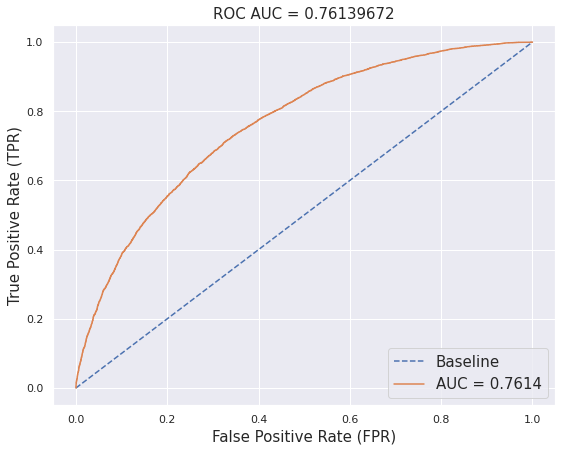

In [23]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier(
        **{
            "lambda_l1": 6.636833602368837,
            "lambda_l2": 0.3221308023736357,
            "num_leaves": 100,
            "feature_fraction": 0.4172192685978952,
            "bagging_fraction": 0.6148275061564304,
            "bagging_freq": 1,
            "min_child_samples": 86,
        }
    )
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)


[LightGBM] [Warning] bagging_fraction is set=0.4253162307244565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4253162307244565
[LightGBM] [Warning] lambda_l1 is set=2.3120410555682672e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3120410555682672e-06
[LightGBM] [Warning] feature_fraction is set=0.6580505530701052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6580505530701052
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.2760268497729425e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2760268497729425e-07


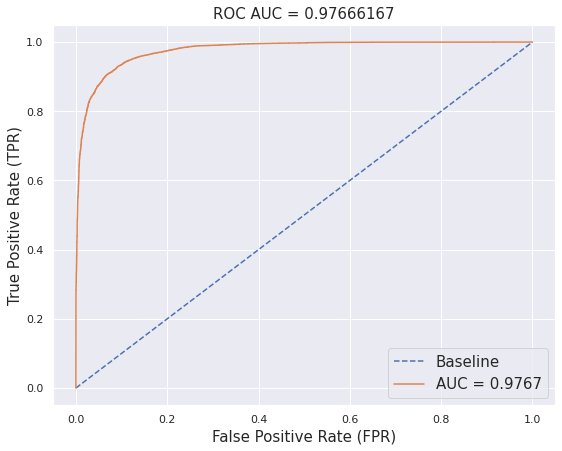

In [ ]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier(
        **{
            "lambda_l1": 2.3120410555682672e-06,
            "lambda_l2": 1.2760268497729425e-07,
            "num_leaves": 256,
            "feature_fraction": 0.6580505530701052,
            "bagging_fraction": 0.4253162307244565,
            "bagging_freq": 4,
            "min_child_samples": 9,
        }
    )
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
) # kaggle 0.31080


# final model

In [24]:
# model = CatBoostClassifier() # kaggle 0.33794
# model = LGBMClassifier() # kaggle 0.33657
# model = LogisticRegression(solver='saga', max_iter=1000, random_state=random_seed) # kaggle 0.33933
model = LGBMClassifier(
    **{
        "lambda_l1": 6.636833602368837,
        "lambda_l2": 0.3221308023736357,
        "num_leaves": 100,
        "feature_fraction": 0.4172192685978952,
        "bagging_fraction": 0.6148275061564304,
        "bagging_freq": 1,
        "min_child_samples": 86,
    }
) # kaggle 0.33999

# model.fit(X_us, y_us)
model.fit(X_train_us, y_train_us)
predict_submission = model.predict(test_data)


[LightGBM] [Warning] bagging_fraction is set=0.6148275061564304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6148275061564304
[LightGBM] [Warning] lambda_l1 is set=6.636833602368837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.636833602368837
[LightGBM] [Warning] feature_fraction is set=0.4172192685978952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4172192685978952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.3221308023736357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3221308023736357


# submision

In [25]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

In [26]:
# !kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"

# Kaggle score: $0.33999$